<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# **Space X  Falcon 9 First Stage Landing Prediction**


## Assignment:  Machine Learning Prediction


Estimated time needed: **60** minutes


Space X advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against space X for a rocket launch.   In this lab, you will create a machine learning pipeline  to predict if the first stage will land given the data from the preceding labs.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


Most unsuccessful landings are planed. Space X; performs a controlled landing in the oceans.


## Objectives


Perform exploratory  Data Analysis and determine Training Labels

*   create a column for the class
*   Standardize the data
*   Split into training data and test data

\-Find best Hyperparameter for SVM, Classification Trees and Logistic Regression

*   Find the method performs best using test data


## Import Libraries and Define Auxiliary Functions


In [1]:
# import piplite
# await piplite.install(['numpy'])
# await piplite.install(['pandas'])
# await piplite.install(['seaborn'])
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install matplotlib
# !pip install cuml-cu11 --extra-index-url=https://pypi.nvidia.com

We will import the following libraries for the lab


In [2]:
# --- Data Manipulation and Analysis ---
import pandas as pd
import numpy as np

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- scikit-learn Preprocessing and Model Selection ---
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# --- scikit-learn Machine Learning Algorithms ---
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# --- cuML Libraries ---
import cudf
import cupy as cp
from cuml.svm import SVC as cumlSVC
from cuml.linear_model import LogisticRegression as cumlLogisticRegression
from cuml.neighbors import KNeighborsClassifier as cumlKNeighborsClassifier
# from cuml.tree import DecisionTreeClassifier as cumlDecisionTreeClassifier
from cuml.model_selection import train_test_split as cuml_train_test_split
from cuml.model_selection import GridSearchCV as cumlGridSearchCV
from cuml.preprocessing import StandardScaler as cumlScaler
from cuml.preprocessing import MinMaxScaler as cumlMinMaxScaler
from cuml.preprocessing import LabelEncoder as cumlLabelEncoder
from cuml.preprocessing import PolynomialFeatures as cumlPolynomialFeatures
from cuml.metrics import accuracy_score as cuml_accuracy_score
from cuml.metrics import confusion_matrix as cuml_confusion_matrix

This function is to plot the confusion matrix.


In [3]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y, y_predict):
    "this function plots the confusion matrix"
    
    # Convert cuML arrays to NumPy arrays if necessary
    if hasattr(y, 'get'):
        y = y.get()
    if hasattr(y_predict, 'get'):
        y_predict = y_predict.get()
    
    # Compute the confusion matrix
    cm = confusion_matrix(y, y_predict)
    
    # Plot the confusion matrix
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax)  # annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['did not land', 'land'])
    ax.yaxis.set_ticklabels(['did not land', 'landed'])
    plt.show()

## Load the dataframe


Load the data


In [4]:

URL1 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
data = cudf.read_csv(URL1)

In [5]:
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,<NA>,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,<NA>,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,<NA>,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,<NA>,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,<NA>,1.0,0,B1004,-80.577366,28.561857,0


In [6]:
URL2 = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv'
X= cudf.read_csv(URL2)  

In [7]:
X.head(10)

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
5,6.0,3325.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
6,7.0,2296.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
7,8.0,1316.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
8,9.0,4535.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
9,10.0,4428.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


## TASK  1


Create a NumPy array from the column <code>Class</code> in <code>data</code>, by applying the method <code>to_numpy()</code>  then
assign it  to the variable <code>Y</code>,make sure the output is a  Pandas series (only one bracket df\['name of  column']).


In [8]:
#Y =pd.Series(data['Class'].to_numpy())
Y =data['Class'].to_numpy()


## TASK  2


Standardize the data in <code>X</code> then reassign it to the variable  <code>X</code> using the transform provided below.


In [9]:
# students get this 
scaler = cumlScaler()
X = scaler.fit_transform(X)

We split the data into training and testing data using the  function  <code>train_test_split</code>.   The training data is divided into validation data, a second set used for training  data; then the models are trained and hyperparameters are selected using the function <code>GridSearchCV</code>.


## TASK  3


Use the function train_test_split to split the data X and Y into training and test data. Set the parameter test_size to  0.2 and random_state to 2. The training data and test data should be assigned to the following labels.


<code>X_train, X_test, Y_train, Y_test</code>


In [10]:
X_train, X_test, Y_train, Y_test = cuml_train_test_split(X, Y, test_size=0.2, random_state=2)

we can see we only have 18 test samples.


In [11]:
Y_test.shape

(18,)

## TASK  4


Create a logistic regression object  then create a  GridSearchCV object  <code>logreg_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [12]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],}


In [13]:

lr= cumlLogisticRegression()
#GridSearchCV object logreg_cv with cv = 10
logreg_cv= cumlGridSearchCV(lr, parameters, cv=10)
# Fit the GridSearchCV object to your data
logreg_cv.fit(X, Y)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2']})

We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.


In [14]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2'}
accuracy : 0.8222222328186035


## TASK  5


Calculate the accuracy on the test data using the method <code>score</code>:


In [15]:
logreg_score = logreg_cv.score(X_test, Y_test)
print("Accuracy on test data: ",logreg_score)

Accuracy on test data:  0.8888888955116272


Lets look at the confusion matrix:


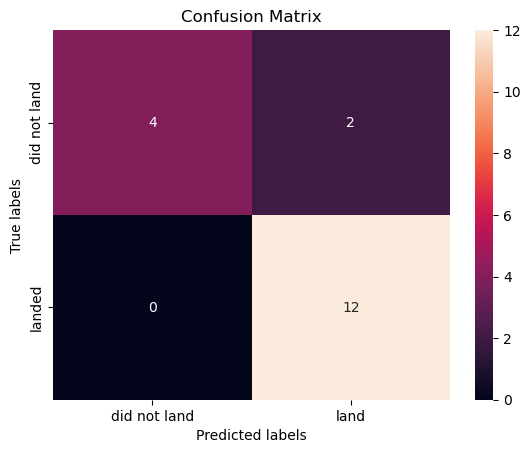

In [16]:

# Predict the values using the logistic regression model
logreg_yhat = logreg_cv.predict(X_test)

# Convert yhat to a NumPy array
logreg_yhat = logreg_yhat.to_numpy()

# Plot the confusion matrix
plot_confusion_matrix(Y_test, logreg_yhat)

# Examining the confusion matrix, we see that logistic regression can distinguish between the different classes.  We see that the problem is false positives.

Overview:

True Postive - 12 (True label is landed, Predicted label is also landed)

False Postive - 1 (True label is not landed, Predicted label is landed)


## TASK  6


Create a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [17]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = cumlSVC()

# Create a GridSearchCV object with 10-fold cross-validation
svm_cv = cumlGridSearchCV(svm, parameters, cv=10)

In [18]:

# Fit the GridSearchCV object to the training data
svm_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [19]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': np.float64(31.622776601683793), 'gamma': np.float64(0.001), 'kernel': 'linear'}
accuracy : 0.8482142925262451


## TASK  7


Calculate the accuracy on the test data using the method <code>score</code>:


In [20]:
svm_cv_score = svm_cv.score(X_test, Y_test)
print("Score: ",svm_cv_score)

Score:  0.7777777910232544


We can plot the confusion matrix


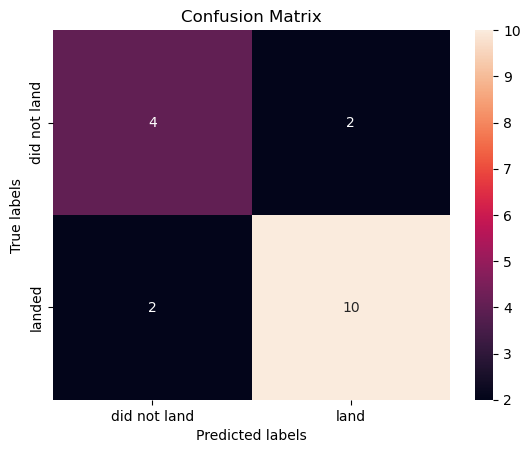

In [21]:
svm_yhat=svm_cv.predict(X_test)
svm_yhat = svm_yhat.to_numpy()
plot_confusion_matrix(Y_test,svm_yhat)

## TASK  8


Create a decision tree classifier object then  create a  <code>GridSearchCV</code> object  <code>tree_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [22]:
# for sklearn
# parameters = {'criterion': ['gini', 'entropy'],
#      'splitter': ['best', 'random'],
#      'max_depth': [2*n for n in range(1,10)],
#      'max_features': ['auto', 'sqrt'],
#      'min_samples_leaf': [1, 2, 4],
#      'min_samples_split': [2, 5, 10]}

#for cuml
from cuml.ensemble import RandomForestClassifier
parameters = {
    'n_estimators': [1],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2*n for n in range(1, 10)],
    'max_features': ['sqrt','log2'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}
tree = RandomForestClassifier()

In [23]:
tree_cv = cumlGridSearchCV(tree, parameters, cv=10)
tree_cv.fit(X_train, Y_train)



/home/panta7r/miniconda3/envs/rapids-24.12/lib/python3.12/site-packages/cuml/internals/api_decorators.py:188: UserWarning: The number of bins, `n_bins` is greater than the number of samples used for training. Changing `n_bins` to number of training samples.
  ret = func(*args, **kwargs)
/home/panta7r/miniconda3/envs/rapids-24.12/lib/python3.12/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/panta7r/miniconda3/envs/rapids-24.12/lib/python3.12/site-packages/cuml/internals/api_decorators.py:188: UserWarning: The number of bins, `n_bins` is greater than the number of samples used for training. Changing `n_bins` to number of training samples.
  ret = func(*args, **kwargs)
/home/panta7r/miniconda3/envs/rapids-24.12/lib/python3.12/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10], 'n_estimators': [1]})

In [24]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'bootstrap': False, 'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1}
accuracy : 0.8482142925262451


## TASK  9


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [25]:
tree_cv_score = tree_cv.score(X_test, Y_test)
print("Score: ",tree_cv_score)

Score:  0.8333333134651184


We can plot the confusion matrix


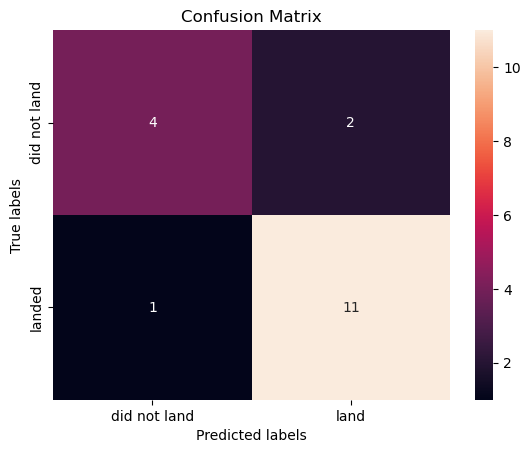

In [26]:
tree_yhat = tree_cv.predict(X_test)
tree_yhat = tree_yhat.to_numpy()
plot_confusion_matrix(Y_test,tree_yhat)

## TASK  10


Create a k nearest neighbors object then  create a  <code>GridSearchCV</code> object  <code>knn_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [27]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
KNN = KNeighborsClassifier()

In [28]:
# Convert cudf DataFrame to NumPy array if it's not already a NumPy array
if isinstance(X_train, cudf.DataFrame):
    X_train_np = X_train.to_numpy()
else:
    X_train_np = X_train

if isinstance(Y_train, cudf.DataFrame):
    Y_train_np = Y_train.to_numpy()
else:
    Y_train_np = Y_train

# Perform GridSearchCV with the converted NumPy arrays
knn_cv = GridSearchCV(estimator=KNN, cv=10, param_grid=parameters).fit(X_train_np, Y_train_np)

Calculate the accuracy on the test data using the method <code>score</code>:


In [29]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1}
accuracy : 0.6785714285714286


## TASK  11


Calculate the accuracy of knn_cv on the test data using the method <code>score</code>:


In [30]:
# Convert cudf DataFrame to NumPy array if it's not already a NumPy array
if isinstance(X_test, cudf.DataFrame):
    X_test_np = X_test.to_numpy()
else:
    X_test_np = X_test

if isinstance(y_test, cudf.DataFrame):
    y_test_np = y_test.to_numpy()
else:
    y_test_np = y_test

# Calculate the score using the converted NumPy arrays
knn_cv_score = knn_cv.score(X_test_np, y_test_np)
print("Score: ",knn_cv_score)

Score:  0.6111111111111112


We can plot the confusion matrix


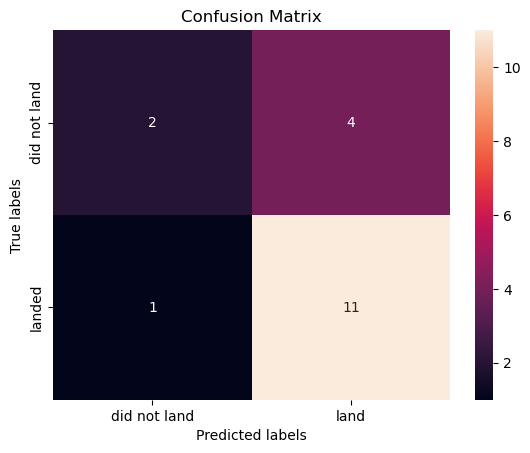

In [31]:
# Convert cudf DataFrame to NumPy array
X_test_np = X_test.to_numpy()

# Predict the values using the KNN model
knn_yhat = knn_cv.predict(X_test_np)

# Plot the confusion matrix
plot_confusion_matrix(Y_test, knn_yhat)

## TASK  12


Find the method performs best:


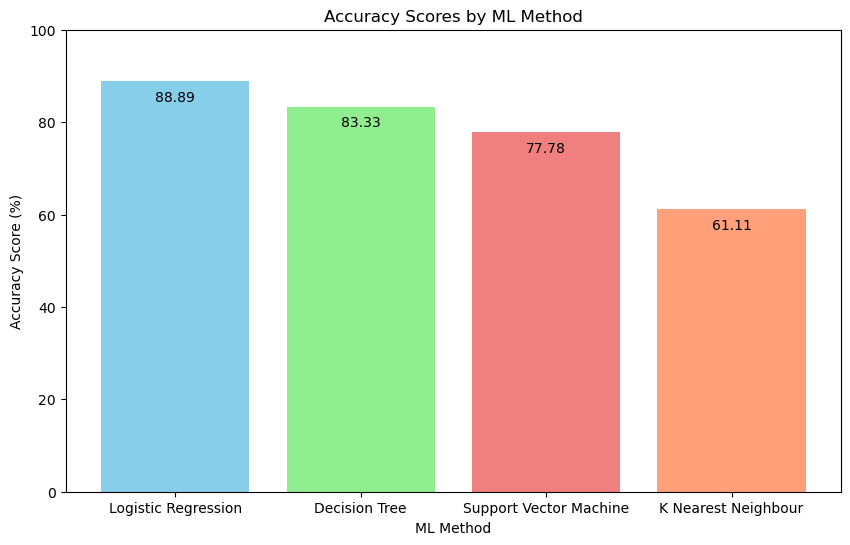

In [33]:
# Calculate accuracy in percentage
accuracy = [svm_cv_score, logreg_score, knn_cv_score, tree_cv_score]
accuracy = [i * 100 for i in accuracy]

# Define methods
method = ['Support Vector Machine', 'Logistic Regression', 'K Nearest Neighbour', 'Decision Tree']
models = {'ML Method': method, 'Accuracy Score (%)': accuracy}

# Create DataFrame
ML_df = pd.DataFrame(models)

# Sort DataFrame by accuracy in descending order
ML_df = ML_df.sort_values(by='Accuracy Score (%)', ascending=False)

# Create bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(ML_df['ML Method'], ML_df['Accuracy Score (%)'], color=['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon'])

# Add accuracy scores on top of the bars
for bar, value in zip(bars, ML_df['Accuracy Score (%)']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 5, f'{value:.2f}', ha='center', va='bottom', color='black')

plt.xlabel('ML Method')
plt.ylabel('Accuracy Score (%)')
plt.title('Accuracy Scores by ML Method')
plt.ylim(0, 100)  # Assuming accuracy scores are between 0 and 100
plt.show()

## Authors


[Pratiksha Verma](https://www.linkedin.com/in/pratiksha-verma-6487561b1/)


<!--## Change Log--!>


<!--| Date (YYYY-MM-DD) | Version | Changed By      | Change Description      |
| ----------------- | ------- | -------------   | ----------------------- |
| 2022-11-09        | 1.0     | Pratiksha Verma | Converted initial version to Jupyterlite|--!>


### <h3 align="center"> IBM Corporation 2022. All rights reserved. <h3/>
